In [2]:
from collections import defaultdict

import numpy as np
import matplotlib.pylab as plt
import pandas as pd

# scikit-hep
import awkward as ak
import uproot
import vector
vector.register_awkward()
import correctionlib

### Load data from NTuples without materialising in memory

!! Install `xrootd` via `conda-forge`

In [3]:
datasets = {
    #"signal": "/Users/moaly/Work/iris-hep/autodiff-analysis-MODE/z-prime-ttbar-gradients/preproc_uproot/z-prime-ttbar-data/signal__nominal/file__0/part0.root", #"root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/ZprimeToTT_M2000_W20_TuneCP2_PSweights_13TeV-madgraph-pythiaMLM-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/280000/45046F71-EB72-974D-BF4A-56A9C1B44524.root",
    # #"root://eospublic.cern.ch//eos/opendata/cms/Run2016H/SingleMuon/NANOAOD/UL2016_MiniAODv2_NanoAODv9-v1/280000/40EA32B0-1284-7246-83A3-A703D908F9FC.root",
    # #"root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/ZprimeToTT_M2000_W20_TuneCP2_PSweights_13TeV-madgraph-pythiaMLM-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/270000/22BAB5D2-9E3F-E440-AB30-AE6DBFDF6C83.root",
    #"tt_semilep": 'root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/120000/08FCB2ED-176B-064B-85AB-37B898773B98.root' #"root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/280000/0605BFCA-C65A-CA4C-8A6A-9148DC1B7B9A.root",
    "tt_semilep": "/Users/moaly/Work/iris-hep/autodiff-analysis-MODE/z-prime-ttbar-gradients/preproc_uproot/z-prime-ttbar-data/signal__nominal/file__0/part0.root"
    # #"root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/120000/08FCB2ED-176B-064B-85AB-37B898773B98.root",
    # "tt_had": "root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/TTToHadronic_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/280000/0415B772-3CC8-A64E-9410-E622E18AF2E5.root",
    # #"root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/TTToHadronic_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/130000/009086DB-1E42-7545-9A35-1433EC89D04B.root",
    # "tt_lep": "root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/280000/6293BAC8-2AB6-4A4A-BFEA-83E328B9C44F.root",
    # #"root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/120000/4A9AFE65-CC58-044A-AFBB-F4CAEA0A7FCD.root",
    # "Wjets": "root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/WJetsToLNu_TuneCP5_13TeV-madgraphMLM-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/280000/06169F6B-C5AE-1646-87E4-F6613C6046C7.root",
    #"root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/WJetsToLNu_TuneCP5_13TeV-madgraphMLM-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/270000/00702195-E707-3743-8BBA-57EB9DEE1DBA.root",
    #"data": "/Users/moaly/Work/iris-hep/autodiff-analysis-MODE/z-prime-ttbar-gradients/preproc_uproot/z-prime-ttbar-data/data__nominal/file__0/part0.root" #"root://eospublic.cern.ch//eos/opendata/cms/Run2016H/SingleMuon/NANOAOD/UL2016_MiniAODv2_NanoAODv9-v1/280000/40EA32B0-1284-7246-83A3-A703D908F9FC.root",
    #"root://eospublic.cern.ch//eos/opendata/cms/Run2016H/SingleMuon/NANOAOD/UL2016_MiniAODv2_NanoAODv9-v1/130000/0DEE1709-0416-F24B-ACB2-C68997CB6465.root"
}

events = defaultdict(dict)
for dataset, filename in datasets.items():
    print(f"Opening {dataset} file: {filename}")
    # Open the file
    with uproot.open(filename) as f:
        f = uproot.open(filename)
        events[dataset]= {"events": f['Events']}
        nevents = events[dataset]["events"].num_entries
        events[dataset].update({"nevents": nevents})
        print(f"{dataset}: {nevents = }")

Opening tt_semilep file: /Users/moaly/Work/iris-hep/autodiff-analysis-MODE/z-prime-ttbar-gradients/preproc_uproot/z-prime-ttbar-data/signal__nominal/file__0/part0.root
tt_semilep: nevents = 100152


### Read branches into memory 

In [4]:
for dataset, data in events.items():
    dataset_events = data["events"]
    print(f"Processing {dataset} dataset")
    # Load the branches we need
    events[dataset]["muon_pt"] = dataset_events["Muon_pt"].array()
    events[dataset]["muon_eta"] = dataset_events["Muon_eta"].array()
    events[dataset]["muon_phi"] = dataset_events["Muon_phi"].array()
    events[dataset]["muon_mass"] = dataset_events["Muon_mass"].array()
    events[dataset]["muon_iso"] = dataset_events["Muon_miniIsoId"].array()
    events[dataset]["muon_tightId"] = dataset_events["Muon_tightId"].array()

    events[dataset]["fatjet_tag"] = dataset_events["FatJet_particleNet_TvsQCD"].array()
    events[dataset]["fatjet_pt"] = dataset_events["FatJet_pt"].array()
    events[dataset]["fatjet_eta"] = dataset_events["FatJet_eta"].array()
    events[dataset]["fatjet_phi"] = dataset_events["FatJet_phi"].array()
    events[dataset]["fatjet_mass"] = dataset_events["FatJet_mass"].array()

    events[dataset]["jet_btag"] = dataset_events["Jet_btagDeepB"].array()
    events[dataset]["jet_jetid"] = dataset_events["Jet_jetId"].array()
    events[dataset]["jet_pt"] = dataset_events["Jet_pt"].array()
    events[dataset]["jet_eta"] = dataset_events["Jet_eta"].array()
    events[dataset]["jet_phi"] = dataset_events["Jet_phi"].array()
    events[dataset]["jet_mass"] = dataset_events["Jet_mass"].array()

    events[dataset]["met_pt"] = dataset_events["PuppiMET_pt"].array()
    events[dataset]["met_eta"] = 0 * dataset_events["PuppiMET_pt"].array()  # Fix this to be 0 !!
    events[dataset]["met_phi"] = dataset_events["PuppiMET_phi"].array()
    #==================== Event variables =========================
    events[dataset]["ht_lep"] = events[dataset]["muon_pt"] + events[dataset]["met_pt"]

    # meta
    if dataset != "data":
        events[dataset]["weights"] = dataset_events["genWeight"].array()
        events[dataset]["nTrueInt"] = dataset_events["Pileup_nTrueInt"].array()
    else:
        events[dataset]["weights"] = np.ones(events[dataset]["nevents"])
        events[dataset]["nTrueInt"] = np.ones(events[dataset]["nevents"])

Processing tt_semilep dataset


### Define object and event selection

In [5]:
#https://github.com/cms-opendata-workshop/workshop2024-lesson-event-selection/blob/main/instructors/dpoa_workshop_utilities.py
def build_lumi_mask(lumifile, tree, verbose=False):

    # lumifile should be the name/path of the file
    good_luminosity_sections = ak.from_json(open(lumifile, 'rb'))
    # Pull out the good runs as integers
    good_runs = np.array(good_luminosity_sections.fields).astype(int)

    # Get the good blocks as an awkward array
    # First loop over to get them as a list
    all_good_blocks = []
    for field in good_luminosity_sections.fields:
        all_good_blocks.append(good_luminosity_sections[field])

    # Turn the list into an awkward array
    all_good_blocks = ak.Array(all_good_blocks)

    # Get the runs and luminosity blocks from the tree
    run = tree['run'].array()
    lumiBlock = tree['luminosityBlock'].array()


    # ChatGPT helped me with this part!
    # Find index of values in arr2 if those values appear in arr1
    def find_indices(arr1, arr2):
        arr1_np = np.asarray(ak.to_numpy(arr1))
        arr2_np = np.asarray(ak.to_numpy(arr2))

        # Sort arr1 and track original indices
        sorter = np.argsort(arr1_np)
        sorted_arr1 = arr1_np[sorter]

        # Search positions
        pos = np.searchsorted(sorted_arr1, arr2_np)

        # Check if arr2 values actually exist in arr1
        valid = (pos < len(arr1_np)) & (sorted_arr1[pos] == arr2_np)

        # Prepare result
        out = np.full(len(arr2_np), -1, dtype=int)
        out[valid] = sorter[pos[valid]]
        return ak.Array(out)

    # Get the indices that say where the good runs are in the lumi file
    # for the runs that appear in the tree
    good_runs_indices = find_indices(good_runs, run)

    # For each event, calculate the difference between the luminosity block for that event
    # and the good luminosity blocks for that run for that event
    diff = lumiBlock - all_good_blocks[good_runs_indices]


    # If the lumi block appears between any of those good block numbers,
    # then one difference will be positive and the other will be negative
    #
    # If it it outside of the range, both differences will be positive or
    # both negative.
    #
    # The product will be negagive if the lumi block is in the range
    # and positive if it is not in the range
    prod_diff = ak.prod(diff, axis=2)
    mask = ak.any(prod_diff<=0, axis=1)

    return mask

In [ ]:
#tau32 = fatjet_tau3/fatjet_tau2
#cut_fatjet = (tau32>0.67) & (fatjet_eta>-2.4) & (fatjet_eta<2.4) & (fatjet_mSD>105) & (fatjet_mSD<220)
for dataset, data in events.items():

    events[dataset]["obj_sel"] = {
        "fatjets": (data["fatjet_pt"] > 500) & (data["fatjet_tag"] > 0.5),
        "muons": (data["muon_pt"] > 55) & (data["muon_eta"] > -2.4) & (data["muon_eta"] < 2.4) &
                (data["muon_tightId"] == True) & (data["muon_iso"] > 1) & (data["ht_lep"] > 150),
        "jets": (data["jet_btag"] > 0.5) & (data["jet_jetid"] >= 4)
    }

    # Event cut
    events[dataset]["event_sel"] = {
        "met": (data["met_pt"] > 50),
        "nmuons": (ak.num(data["muon_pt"][data["obj_sel"]["muons"]], axis=1) == 1),
        #"trigger": (data["events"]["HLT_TkMu50"].array()),
        "btag": (ak.num(data["jet_pt"][data["obj_sel"]["jets"]], axis=1) > 0),
        "ntop": (ak.num(data["fatjet_pt"][data["obj_sel"]["fatjets"]], axis=1) == 1)
    }

    full_event_sel =  (
        (events[dataset]["event_sel"]["nmuons"]) &
        #(events[dataset]["event_sel"]["trigger"]) &
        (events[dataset]["event_sel"]["met"]) &
        (events[dataset]["event_sel"]["ntop"]) &
        (events[dataset]["event_sel"]["btag"]))


    print(dataset)
    if dataset == "data":
        mask_lumi = build_lumi_mask('/Users/moaly/Work/iris-hep/autodiff-analysis-MODE/z-prime-ttbar-gradients/corrections/Cert_271036-284044_13TeV_Legacy2016_Collisions16_JSON.txt', events[dataset]["events"], verbose=False)
        print(mask_lumi)
        full_event_sel = full_event_sel & (mask_lumi)

    events[dataset]["event_sel"]["full"] = full_event_sel

    print(f"Fraction of {dataset} events left: ", ak.sum(full_event_sel)/nevents, "Total left: ",  ak.sum(full_event_sel))

    fatjets = ak.zip(
        {
            "pt": data["fatjet_pt"][full_event_sel][data["obj_sel"]["fatjets"][full_event_sel]],
            "eta": data["fatjet_eta"][full_event_sel][data["obj_sel"]["fatjets"][full_event_sel]],
            "phi": data["fatjet_phi"][full_event_sel][data["obj_sel"]["fatjets"][full_event_sel]],
            "mass": data["fatjet_mass"][full_event_sel][data["obj_sel"]["fatjets"][full_event_sel]],
        },
        with_name="Momentum4D",
    )
    events[dataset]["fatjets"] = fatjets

    muons = ak.zip(
        {
            "pt": data["muon_pt"][full_event_sel][data["obj_sel"]["muons"][full_event_sel]],
            "eta": data["muon_eta"][full_event_sel][data["obj_sel"]["muons"][full_event_sel]],
            "phi": data["muon_phi"][full_event_sel][data["obj_sel"]["muons"][full_event_sel]],
            "mass": data["muon_mass"][full_event_sel][data["obj_sel"]["muons"][full_event_sel]],
        },
        with_name="Momentum4D",
    )
    events[dataset]["muons"] = muons

    jets = ak.zip(
        {
            "pt": data["jet_pt"][full_event_sel][data["obj_sel"]["jets"][full_event_sel]][:, 0],
            "eta": data["jet_eta"][full_event_sel][data["obj_sel"]["jets"][full_event_sel]][:, 0],
            "phi": data["jet_phi"][full_event_sel][data["obj_sel"]["jets"][full_event_sel]][:, 0],
            "mass": data["jet_mass"][full_event_sel][data["obj_sel"]["jets"][full_event_sel]][:, 0],
        },
        with_name="Momentum4D",
    )
    events[dataset]["jets"] = jets

    met = ak.zip(
        {
            "pt": data["met_pt"][data["event_sel"]["full"]],
            "eta": data["met_eta"][data["event_sel"]["full"]],
            "phi": data["met_phi"][data["event_sel"]["full"]],
            "mass": 0,
        },
        with_name="Momentum4D",
    )
    events[dataset]["met"] = met

    p4mu,p4fj,p4j,p4met = ak.unzip(ak.cartesian([muons, fatjets, jets, met]))
    p4tot = p4mu + p4fj + p4j + p4met
    events[dataset]["p4tot"] = p4tot
    events[dataset]['mtt'] = ak.flatten(p4tot.mass)
    events[dataset]['mu_pt'] = ak.flatten(p4mu.pt)
    events[dataset]['mu_abseta'] = np.abs(ak.flatten(p4mu.eta))
    events[dataset]['weight'] = data["weights"][full_event_sel]
    events[dataset]['pileup'] = data["nTrueInt"][full_event_sel]

tt_semilep
Fraction of tt_semilep events left:  0.284527518172378 Total left:  28496


Plotting tt_semilep dataset
(array([ 0.,  0.,  0.,  0.,  1.,  4.,  9., 19., 13.,  8., 17.,  5., 12.,
        9., 16., 22., 24., 28., 22., 29., 41., 37., 28., 33., 31., 29.,
       25., 21., 11., 13., 26.,  3.,  8.,  7.,  9.,  4.,  4.,  4.,  5.,
        2.,  5.,  5.,  3.,  0.,  1.,  1.,  0.,  1.,  0.,  0.]), array([   0.,   60.,  120.,  180.,  240.,  300.,  360.,  420.,  480.,
        540.,  600.,  660.,  720.,  780.,  840.,  900.,  960., 1020.,
       1080., 1140., 1200., 1260., 1320., 1380., 1440., 1500., 1560.,
       1620., 1680., 1740., 1800., 1860., 1920., 1980., 2040., 2100.,
       2160., 2220., 2280., 2340., 2400., 2460., 2520., 2580., 2640.,
       2700., 2760., 2820., 2880., 2940., 3000.]), <BarContainer object of 50 artists>)


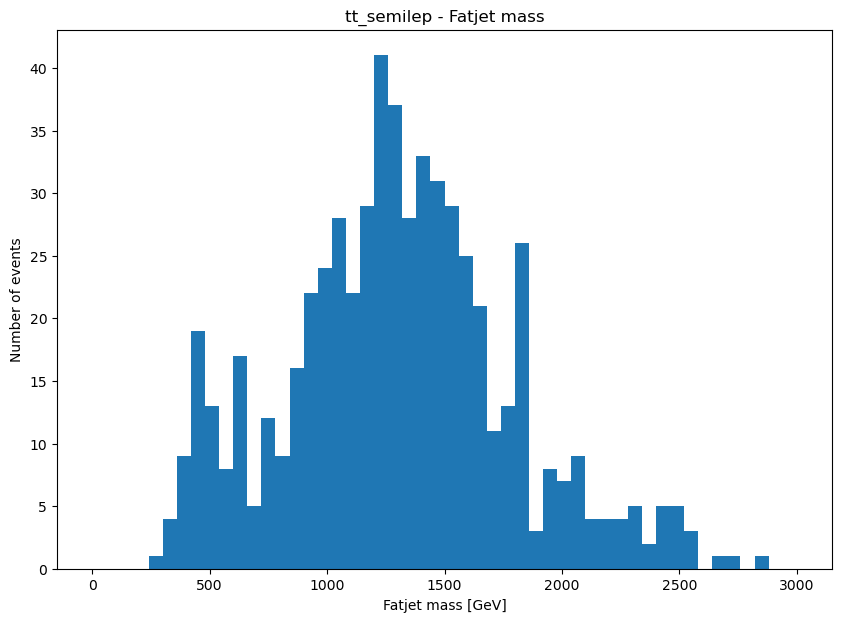

In [9]:
for dataset, data in events.items():
    print(f"Plotting {dataset} dataset")
    p4tot = data["p4tot"]
    # Plotting
    plt.figure(figsize=(10, 7))
    plt.title(f"{dataset} - Fatjet mass")
    c = plt.hist(ak.flatten(p4tot.mass),bins=50, range=(0,3000));
    print(c)
    plt.xlabel("Fatjet mass [GeV]")
    plt.ylabel("Number of events")
    plt.show()

In [10]:

for dataset, data in events.items():
    to_write = {}
    to_write['mtt'] = data['mtt']
    to_write['mu_pt'] = data['mu_pt']
    to_write['mu_abseta'] = data['mu_abseta']

    to_write['weight'] = data["weight"]
    to_write['pileup'] = data["pileup"]
    df = pd.DataFrame.from_dict(to_write)
    outfilename = f"output_{dataset}_{filename.split('/')[-1].split('.')[0]}.csv"
    df.to_csv(outfilename, index=False)

In [11]:
import gzip
with gzip.open("../corrections/puWeights.json.gz",'rt') as file:
    data = file.read().strip()
    pu_corr_evaluator = correctionlib.CorrectionSet.from_string(data)

with gzip.open("../corrections/muon_Z.json.gz",'rt') as file:
    data = file.read().strip()
    muo_corr_evaluator = correctionlib.CorrectionSet.from_string(data)

In [29]:
datadict = {}
#datadict['signal'] = np.genfromtxt('/Users/moaly/Work/iris-hep/autodiff-analysis-MODE/z-prime-ttbar-gradients/_legacy/output_signal_part0.csv', delimiter=',', names=True, dtype=float) #'output_signal_40EA32B0-1284-7246-83A3-A703D908F9FC.csv'
datadict['tt_semilep'] = np.genfromtxt("./SUMMED_ttsemilep.csv", delimiter=',', names=True, dtype=float) #np.genfromtxt('output_tt_semilep_08FCB2ED-176B-064B-85AB-37B898773B98.csv', delimiter=',', names=True, dtype=float)
# datadict['tt_had'] = np.genfromtxt('output_tt_had_40EA32B0-1284-7246-83A3-A703D908F9FC.csv', delimiter=',', names=True, dtype=float)
# datadict['data'] = np.genfromtxt('output_data_40EA32B0-1284-7246-83A3-A703D908F9FC.csv', delimiter=',', names=True, dtype=float)

hists = {}
for sample in datadict.keys():
    print(sample)
    hists[sample] = {
        "pu": datadict[sample]['pileup'],
        "mu_pt": datadict[sample]['mu_pt'],
        "mu_abseta": datadict[sample]['mu_abseta'],
        "genWeight": datadict[sample]['weight']/np.abs(datadict[sample]['weight']),
        "Ngen": np.abs(datadict[sample]['N_gen']),
        "mtt": datadict[sample]['mtt'],
        "pu_weight": pu_corr_evaluator["Collisions16_UltraLegacy_goldenJSON"].evaluate(np.asarray(datadict[sample]['pileup']), "nominal"),
        "pu_weight_up": pu_corr_evaluator["Collisions16_UltraLegacy_goldenJSON"].evaluate(np.asarray(datadict[sample]['pileup']), "up"),
        "pu_weight_dn": pu_corr_evaluator["Collisions16_UltraLegacy_goldenJSON"].evaluate(np.asarray(datadict[sample]['pileup']), "down"),
        "leadmuon_sf": muo_corr_evaluator["NUM_TightID_DEN_TrackerMuons"].evaluate(datadict[sample]['mu_abseta'],datadict[sample]['mu_pt'],"nominal"),
        "leadmuon_sf_up": muo_corr_evaluator["NUM_TightID_DEN_TrackerMuons"].evaluate(datadict[sample]['mu_abseta'],datadict[sample]['mu_pt'],"systup"),
        "leadmuon_sf_dn": muo_corr_evaluator["NUM_TightID_DEN_TrackerMuons"].evaluate(datadict[sample]['mu_abseta'],datadict[sample]['mu_pt'],"systdown"),
    }

tt_semilep


In [25]:
plt.hist(hists['signal']['mtt'],
         bins=50,range=(0,3000),
         weights=hists['signal']['genWeight']*hists['signal']['pu_weight'],
         histtype="step",color="k",label="nominal")
plt.hist(hists['signal']['mtt'],
         bins=50,range=(0,3000),
         weights=hists['signal']['genWeight']*hists['signal']['pu_weight_up'],
         histtype="step",color="r",label="up")
plt.hist(hists['signal']['mtt'],
         bins=50,range=(0,3000),
         weights=hists['signal']['genWeight']*hists['signal']['pu_weight_dn'],
         histtype="step",color="b",label="down")
plt.legend()
plt.xlabel('ttbar mass (GeV)')
plt.ylabel('events / 60 GeV')
plt.show()

plt.hist(hists['signal']['pu'],
         bins=50,range=(0,50),
         weights=hists['signal']['genWeight']*hists['signal']['pu_weight'],
         histtype="step",color="k",label="nominal")
plt.hist(hists['signal']['pu'],
         bins=50,range=(0,50),
         weights=hists['signal']['genWeight']*hists['signal']['pu_weight_up'],
         histtype="step",color="r",label="up")
plt.hist(hists['signal']['pu'],
         bins=50,range=(0,50),
         weights=hists['signal']['genWeight']*hists['signal']['pu_weight_dn'],
         histtype="step",color="b",label="down")
plt.legend()
plt.xlabel('N true interactions')
plt.ylabel('events')
plt.show()

plt.hist(hists['signal']['mu_pt'],
         bins=50,range=(0,50),
         weights=hists['signal']['genWeight']*hists['signal']['leadmuon_sf'],
         histtype="step",color="k",label="nominal")
plt.hist(hists['signal']['pu'],
         bins=50,range=(0,50),
         weights=hists['signal']['genWeight']*hists['signal']['leadmuon_sf_up'],
         histtype="step",color="r",label="up")
plt.hist(hists['signal']['pu'],
         bins=50,range=(0,50),
         weights=hists['signal']['genWeight']*hists['signal']['leadmuon_sf_dn'],
         histtype="step",color="b",label="down")
plt.legend()
plt.xlabel('Muon pT (GeV)')
plt.ylabel('events')
plt.show()

KeyError: 'signal'

In [30]:
import pickle
with open('hists_for_ROOT.p','wb') as f:
    pickle.dump(hists,f)

In [51]:
import hist
import pickle
import numpy as np

info = {'signal': {"xsec": 1.0, "binning": (0, 3000, 50)},
        'tt_semilep': {"xsec": 831.76*0.438, "binning": (0, 3000, 50)},
        'tt_had': {"xsec": 831.76*0.457, "binning": (0, 3000, 50)},
        }

with open('hists_for_ROOT.p','rb') as f:
    hists = pickle.load(f)


SYSTEMATICS = {
    "leadmuon_sf": {
        "up": "leadmuon_sf_up",
        "dn": "leadmuon_sf_dn",
        "nominal": "leadmuon_sf",
        "type": "weight",
    },
    "pu_weight": {
        "up": "pu_weight_up",
        "dn": "pu_weight_dn",
        "nominal": "pu_weight",
        "type": "weight",
    },
}

observable_name = "mtt"
ndhist = ( hist.Hist.new.Reg(50, 0, 3000, name="observable", label=f"{observable_name} [GeV]")
          .StrCat([], name="process", label="Process", growth=True)
          .StrCat([], name="variation", label="Systematic variation", growth=True)
          .Weight()
        )

for process, process_info in hists.items():

    print(f"Processing {process} dataset")
    # load observable data
    observable = process_info[observable_name]
    # Handle weights
    if process == "data":
        weight = 1.0
    else:
        genweight = process_info['genWeight']
        print(len(genweight))
        n_gen = process_info['Ngen'] #sum(genweight)
        n_gen = np.sum(np.unique(n_gen))
        print(n_gen)
        lumi_weight = 16400*info[process]["xsec"]*process_info['genWeight']/n_gen
        pu_weight = process_info['pu_weight']
        mu_id_sf = process_info['leadmuon_sf']
        print(genweight, lumi_weight, pu_weight, mu_id_sf)
        weight = genweight * lumi_weight * pu_weight * mu_id_sf

    print("xx", ak.sum(weight), len(weight))
    # Fill nominal histogram
    ndhist.fill(
                observable=observable, process=process,
                variation="nominal", weight=weight,
            )
    if process == "data":
            continue
    for variation, variation_info in SYSTEMATICS.items():
        for direction in ["up", "dn"]:

            syst_var_name = f"{variation}_{direction}"
            var_weight = weight
            if variation_info["type"] == "weight":
                var_weight *= np.asarray(process_info[variation_info[direction]])/np.asarray(process_info[variation_info["nominal"]])

            ndhist.fill(
                        observable=observable, process=process,
                        variation=syst_var_name, weight=var_weight,
                    )

print(ndhist)

Processing tt_semilep dataset
137080
142220866.0
[1. 1. 1. ... 1. 1. 1.] [0.04201 0.04201 0.04201 ... 0.04201 0.04201 0.04201] [0.90235137 0.90235137 0.82405812 ... 0.75676797 1.06102732 1.06102732] [0.98462645 0.98462645 0.99049467 ... 0.97832242 0.96955027 0.96955027]
xx 5703.4361092102945 137080
Hist(
  Regular(50, 0, 3000, name='observable', label='mtt [GeV]'),
  StrCategory(['tt_semilep'], growth=True, name='process', label='Process'),
  StrCategory(['nominal', 'leadmuon_sf_up', 'leadmuon_sf_dn', 'pu_weight_up', 'pu_weight_dn'], growth=True, name='variation', label='Systematic variation'),
  storage=Weight()) # Sum: WeightedSum(value=28209.9, variance=1388.23) (WeightedSum(value=28362.5, variance=1395.74) with flow)


In [46]:
import uproot

hists_dict = {"channel": ndhist}
def save_histograms(hist_dict, filename, add_offset=False):
    with uproot.recreate(filename) as f:
        # save all available histograms to disk
        for channel, histogram in hist_dict.items():
            # optionally add minimal offset to avoid completely empty bins
            # (useful for the ML validation variables that would need binning adjustment
            # to avoid those)
            if add_offset:
                histogram += 1e-6
                # reference count for empty histogram with floating point math tolerance
                empty_hist_yield = histogram.axes[0].size*(1e-6)*1.01
            else:
                empty_hist_yield = 0

            for sample in histogram.axes[1]:
                for variation in histogram[:, sample, :].axes[1]:
                    variation_string = "" if variation == "nominal" else f"_{variation}"
                    current_1d_hist = histogram[:, sample, variation]

                    if sum(current_1d_hist.values()) > empty_hist_yield:
                        # only save histograms containing events
                        f[f"{channel}_{sample}{variation_string}"] = current_1d_hist

            # Need to build some notion of pseudodata here

save_histograms(hists_dict, "test_hists.root", add_offset=False)

In [ ]:
import cabinetry
from cabinetry.contrib import histogram_reader
import hist

def get_cabinetry_rebinning_router(config, rebinning):
    # perform re-binning in cabinetry by providing a custom function reading histograms
    # will eventually be replaced via https://github.com/scikit-hep/cabinetry/issues/412
    rebinning_router = cabinetry.route.Router()

    # this reimplements some of cabinetry.templates.collect
    general_path = config["General"]["InputPath"]
    variation_path = config["General"].get("VariationPath", None)

    # define a custom template builder function that is executed for data samples
    @rebinning_router.register_template_builder()
    def build_data_hist(region, sample, systematic, template):
        # get path to histogram
        histo_path = cabinetry.templates.collector._histo_path(general_path, variation_path, region, sample, systematic, template)
        h = hist.Hist(histogram_reader.with_uproot(histo_path))  # turn from boost-histogram into hist
        # perform re-binning
        h = h[rebinning]
        return h

    return rebinning_router

cabinetry_config = cabinetry.configuration.load("cabinetry_config.yaml")
rebinning_router = get_cabinetry_rebinning_router(cabinetry_config, rebinning=slice(110j, None, hist.rebin(2)))
cabinetry.templates.build(cabinetry_config, router=rebinning_router)  # build the templates
cabinetry.templates.postprocess(cabinetry_config)  # optional post-processing (e.g. smoothing)
ws = cabinetry.workspace.build(cabinetry_config)
cabinetry.workspace.save(ws, "workspace.json")
model, data = cabinetry.model_utils.model_and_data(ws)
model_prediction = cabinetry.model_utils.prediction(model)
cabinetry.visualize.data_mc(model_prediction, data, close_figure=False, config=cabinetry_config)